In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random
import glob
from scipy.signal import welch
import matplotlib.gridspec as gs

In [2]:
from dask.distributed import Client, LocalCluster
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34533,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:36501,Total threads: 1
Dashboard: /proxy/42693/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:46831,


In [3]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_sst.nc",  use_cftime=True, chunks= {"time":240})
ctrl_sst = ctrl_sst.sst.compute()

In [6]:
ctrl_sst = roll_longitude(ctrl_sst)

In [7]:
VC_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/VAR_PACE_sst.nc",  use_cftime=True, chunks= {"time":240})
VC_sst = VC_sst.sst.compute()

In [8]:
VC_sst = roll_longitude(VC_sst)

In [9]:
OC_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/OC_sst.nc",  use_cftime=True, chunks= {"time":240})
OC_sst = OC_sst.sst.compute()

In [10]:
OC_sst = roll_longitude(OC_sst)

In [11]:
MC_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/MC_sst.nc",  use_cftime=True, chunks= {"time":240})
MC_sst = MC_sst.sst.compute()

In [12]:
MC_sst = roll_longitude(MC_sst)

In [13]:
def roll_longitude(df):
    """
    Rolls the longitude coordinates of a given DataFrame to a range of [0, 360).

    Parameters:
    df (xarray.DataArray): Input DataFrame containing longitude coordinates.

    Returns:
    xarray.DataArray: DataFrame with rolled longitude coordinates.
    """
    # Ensure the longitude coordinates are within the range [0, 360)
    df.coords['xt_ocean'] = (df.coords['xt_ocean']) % 360
    
    # Sort the DataFrame based on the rolled longitude coordinates
    df = df.sortby(df.xt_ocean)
    
    return df


def SSTA(DS):
    """
    Computes the Sea Surface Temperature Anomaly (SSTA) by subtracting the monthly climatology from the input dataset.

    Parameters:
    DS (xarray.Dataset): Input dataset containing SST values.

    Returns:
    xarray.Dataset: Dataset with Sea Surface Temperature Anomaly.
    """
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta

def NINO34(DS):
    """
    Calculates the NINO3.4 index representing the average sea surface temperature anomaly in the NINO3.4 region.

    Parameters:
    DS (xarray.Dataset): Input dataset containing SST values.

    Returns:
    xarray.DataArray: NINO3.4 index calculated from the dataset.
    """
    return SSTA(DS).sel(yt_ocean=slice(-5, 5), xt_ocean=slice(190, 240)).mean(['yt_ocean', 'xt_ocean'])

def IOBM(DS):
    """
    Computes the Indian Ocean Basin Mode (IOBM) by averaging the sea surface temperature anomaly in a specified region.

    Parameters:
    DS (xarray.Dataset): Input dataset containing SST values.

    Returns:
    xarray.DataArray: IOBM calculated from the dataset.
    """
    return SSTA(DS).sel(yt_ocean=slice(-20, 20), xt_ocean=slice(40, 100)).mean(['yt_ocean', 'xt_ocean'])

def DMI(DS):
    """
    Calculates the Dipole Mode Index (DMI) representing the temperature gradient between Western and Southeastern Indian Ocean regions.

    Parameters:
    DS (xarray.Dataset): Input dataset containing SST values.

    Returns:
    xarray.DataArray: DMI calculated from the dataset.
    """
    WTIO = SSTA(DS).sel(yt_ocean=slice(-10, 10), xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    SETIO = SSTA(DS).sel(yt_ocean=slice(-10, 0), xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return (WTIO - SETIO).drop('month')

def EIO(DS):
    """
    Calculates the Eastern Indian Ocean (EIO) index representing the average sea surface temperature anomaly in the Eastern Indian Ocean region.

    Parameters:
    DS (xarray.Dataset): Input dataset containing SST values.

    Returns:
    xarray.DataArray: EIO index calculated from the dataset.
    """
    SETIO = SSTA(DS).sel(yt_ocean=slice(-10, 0), xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return SETIO.drop('month')

def EIO_1(DS):
    """
    Calculates the average sea surface temperature anomaly in the Eastern Indian Ocean region without monthly averaging.

    Parameters:
    DS (xarray.Dataset): Input dataset containing SST values.

    Returns:
    xarray.DataArray: EIO index calculated without monthly averaging.
    """
    SETIO = DS.sel(yt_ocean=slice(-10, 0), xt_ocean=slice(90, 110)).mean(['yt_ocean', 'xt_ocean'])
    return SETIO

def WIO(DS):
    """
    Calculates the Western Indian Ocean (WIO) index representing the average sea surface temperature anomaly in the Western Indian Ocean region.

    Parameters:
    DS (xarray.Dataset): Input dataset containing SST values.

    Returns:
    xarray.DataArray: WIO index calculated from the dataset.
    """
    WTIO = SSTA(DS).sel(yt_ocean=slice(-10, 10), xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    return WTIO.drop('month')

def WIO_1(DS):
    """
    Calculates the average sea surface temperature anomaly in the Western Indian Ocean region without monthly averaging.

    Parameters:
    DS (xarray.Dataset): Input dataset containing SST values.

    Returns:
    xarray.DataArray: WIO index calculated without monthly averaging.
    """
    WTIO = DS.sel(yt_ocean=slice(-10, 10), xt_ocean=slice(50, 70)).mean(['yt_ocean', 'xt_ocean'])
    return WTIO

def IOD_events(ds):
    """
    Identifies Indian Ocean Dipole (IOD) events based on the Dipole Mode Index (DMI) timeseries within specific seasons.

    Parameters:
    ds (xarray.Dataset): Input dataset containing the Dipole Mode Index (DMI) values.

    Returns:
    tuple: Two DataArrays representing negative (nIOD) and positive (pIOD) IOD events.
    """
    # Get the DMI timeseries in seasons starting from DJF, MAM, etc.
    QS = DMI(ds).resample(time='QS-DEC').mean(dim="time")
    
    # Select SON seasons into a timeseries
    SON = QS.groupby('time.season')["SON"]
    
    # Use quantiles to select all events and create DataArrays of nIOD and pIOD event values
    lower, upper = SON.quantile([0.2, 0.8])
    nIOD = SON.where(SON <= lower.values).dropna(dim="time")
    pIOD = SON.where(SON > upper.values).dropna(dim="time")
    
    return nIOD, pIOD

def get_IOD_times(ds_sst, ds_var=None):
    """
    Subsets a variable based on the positive (pIOD) and negative (nIOD) Indian Ocean Dipole events derived from Sea Surface Temperature (SST) dataset.

    Parameters:
    ds_sst (xarray.Dataset): Sea Surface Temperature dataset containing IOD events.
    ds_var (xarray.Dataset, optional): Variable dataset to be subset based on IOD events. Defaults to None.

    Returns:
    tuple: Two subsets of the variable dataset corresponding to positive (subset_ds_pos) and negative (subset_ds_neg) IOD events.
    """
    # Extract positive and negative IOD events based on SST dataset
    nIOD, pIOD = IOD_events(ds_sst)
    
    # Calculate the mean year for nIOD and pIOD
    nIOD = nIOD.groupby("time.year").mean("time").year
    pIOD = pIOD.groupby("time.year").mean("time").year
    
    # If ds_var is not provided, use ds_sst
    if ds_var is None:
        ds_var = ds_sst
    
    # Resample ds_var by season and group by year
    ds_var = ds_var.resample(time='QS-DEC').mean(dim="time").groupby("time.year")
    
    # Initialize empty lists to store subsets
    pos_list = []
    neg_list = []
    
    # Loop through each year group in ds_var and subset based on specific years in nIOD and pIOD
    for year, group in ds_var:
        if year in pIOD:
            pos_subset = group
            pos_list.append(pos_subset)
        elif year in nIOD:
            neg_subset = group
            neg_list.append(neg_subset)
        else:
            pass
    
    # Concatenate subsets into a single DataArray
    subset_ds_pos = xr.concat(pos_list, dim='time')
    subset_ds_neg = xr.concat(neg_list, dim='time')
    
    return subset_ds_pos, subset_ds_neg

def calc_seasonal_TS(ds, season):
    """
    Calculates seasonal mean temperature or other variable from the given dataset for a specified season.

    Parameters:
    ds (xarray.Dataset): Input dataset containing the variable of interest.
    season (str): Season to calculate the mean for (e.g., 'DJF', 'MAM', 'JJA', 'SON').

    Returns:
    xarray.Dataset: Seasonal mean dataset for the specified season.
    """
    # Resample dataset by season and calculate mean for each year
    Seas = ds.resample(time='QS-DEC').mean(dim="time").groupby("time.season")
    
    # Extract the dataset for the specified season and calculate the mean for each year
    seasonal_ds = Seas[season].groupby('time.year').mean("time")
    
    return seasonal_ds

def ENLN_events(ds):
    """
    Identifies El Niño (EN) and La Niña (LN) events based on the Nino3.4 index timeseries within specific seasons.

    Parameters:
    ds (xarray.Dataset): Input dataset containing the Nino3.4 index values.

    Returns:
    tuple: Two DataArrays representing El Niño (EN) and La Niña (LN) events.
    """
    # Get the Nino34 timeseries in seasons starting from DJF, MAM, etc.
    QS = NINO34(ds).resample(time='QS-DEC').mean(dim="time")
    
    # Select DJF seasons into a timeseries
    DJF = QS.groupby('time.season')["DJF"]
    
    # Use quantiles to select all events and create DataArrays of EN and LN event values
    lower, upper = DJF.quantile([0.2, 0.8])
    LN = DJF.where(DJF <= lower.values).dropna(dim="time")
    EN = DJF.where(DJF > upper.values).dropna(dim="time")
    
    return LN, EN

def get_ENLN_times(ds_sst, ds_var=None):
    """
    Subsets a variable based on the positive (EN) and negative (LN) El Niño/La Niña events derived from Sea Surface Temperature (SST) dataset.

    Parameters:
    ds_sst (xarray.Dataset): Sea Surface Temperature dataset containing Nino3.4 index events.
    ds_var (xarray.Dataset, optional): Variable dataset to be subset based on ENLN events. Defaults to None.

    Returns:
    tuple: Two subsets of the variable dataset corresponding to positive (subset_ds_pos) and negative (subset_ds_neg) ENLN events.
    """
    # Extract positive (EN) and negative (LN) ENLN events based on SST dataset
    LN, EN = ENLN_events(ds_sst)
    
    # Calculate the mean year for LN and EN
    LN = LN.groupby("time.year").mean("time").year
    EN = EN.groupby("time.year").mean("time").year
    
    # If ds_var is not provided, use ds_sst
    if ds_var is None:
        ds_var = ds_sst
    
    # Resample ds_var by season and group by year
    ds_var = ds_var.resample(time='QS-DEC').mean(dim="time").groupby("time.year")
    
    # Initialize empty lists to store subsets
    pos_list = []
    neg_list = []
    
    # Loop through each year group in ds_var and subset based on specific years in LN and EN
    for year, group in ds_var:
        if year in EN:
            pos_subset = group
            pos_list.append(pos_subset)
        elif year in LN:
            neg_subset = group
            neg_list.append(neg_subset)
        else:
            pass
    
    # Concatenate subsets into a single DataArray
    subset_ds_pos = xr.concat(pos_list, dim='time')
    subset_ds_neg = xr.concat(neg_list, dim='time')
    
    return subset_ds_pos, subset_ds_neg


In [14]:
def IOD_events_early(ds):
    """
    Identifies Indian Ocean Dipole (IOD) events based on the Dipole Mode Index (DMI) timeseries within specific seasons.

    Parameters:
    ds (xarray.Dataset): Input dataset containing the Dipole Mode Index (DMI) values.

    Returns:
    tuple: Two DataArrays representing negative (nIOD) and positive (pIOD) IOD events.
    """
    # Get the DMI timeseries in seasons starting from DJF, MAM, etc.
    QS = DMI(ds).resample(time='QS-DEC').mean(dim="time")
    
    # Select SON seasons into a timeseries
    SON = QS.groupby('time.season')["JJA"]
    
    # Use quantiles to select all events and create DataArrays of nIOD and pIOD event values
    lower, upper = SON.quantile([0.2, 0.8])
    nIOD = SON.where(SON <= lower.values).dropna(dim="time")
    pIOD = SON.where(SON > upper.values).dropna(dim="time")
    
    return nIOD, pIOD

In [15]:
def IOD_events_prolonged(ds):
    """
    Identifies Indian Ocean Dipole (IOD) events based on the Dipole Mode Index (DMI) timeseries within specific seasons.

    Parameters:
    ds (xarray.Dataset): Input dataset containing the Dipole Mode Index (DMI) values.

    Returns:
    tuple: Two DataArrays representing negative (nIOD) and positive (pIOD) IOD events.
    """
    # Get the DMI timeseries in seasons starting from DJF, MAM, etc.
    QS = DMI(ds).resample(time='QS-DEC').mean(dim="time")
    
    # Select SON seasons into a timeseries
    SON = QS.groupby('time.season')["SON"]
    
    # Use quantiles to select all events and create DataArrays of nIOD and pIOD event values
    lower, upper = SON.quantile([0.2, 0.8])
    nIOD = SON.where(SON <= lower.values).dropna(dim="time")
    pIOD = SON.where(SON > upper.values).dropna(dim="time")
    
    return nIOD, pIOD

In [16]:
def get_IOD_times_early(ds_sst, ds_var=None):
    """
    Subsets a variable based on the positive (pIOD) and negative (nIOD) Indian Ocean Dipole events derived from Sea Surface Temperature (SST) dataset.

    Parameters:
    ds_sst (xarray.Dataset): Sea Surface Temperature dataset containing IOD events.
    ds_var (xarray.Dataset, optional): Variable dataset to be subset based on IOD events. Defaults to None.

    Returns:
    tuple: Two subsets of the variable dataset corresponding to positive (subset_ds_pos) and negative (subset_ds_neg) IOD events.
    """
    # Extract positive and negative IOD events based on SST dataset
    nIOD, pIOD = IOD_events_early(ds_sst)
    
    # Calculate the mean year for nIOD and pIOD
    nIOD = nIOD.groupby("time.year").mean("time").year
    pIOD = pIOD.groupby("time.year").mean("time").year
    
    # If ds_var is not provided, use ds_sst
    if ds_var is None:
        ds_var = ds_sst
    
    # Resample ds_var by season and group by year
    ds_var = ds_var.groupby("time.year")
    
    # Initialize empty lists to store subsets
    pos_list = []
    neg_list = []
    
    # Loop through each year group in ds_var and subset based on specific years in nIOD and pIOD
    for year, group in ds_var:
        if year in pIOD:
            pos_subset = group
            pos_list.append(pos_subset)
        elif year in nIOD:
            neg_subset = group
            neg_list.append(neg_subset)
        else:
            pass
    
    # Concatenate subsets into a single DataArray
    subset_ds_pos = xr.concat(pos_list, dim='time')
    subset_ds_neg = xr.concat(neg_list, dim='time')
    
    return subset_ds_pos, subset_ds_neg

In [17]:
def get_IOD_times(ds_sst, ds_var=None):
    """
    Subsets a variable based on the positive (pIOD) and negative (nIOD) Indian Ocean Dipole events derived from Sea Surface Temperature (SST) dataset.

    Parameters:
    ds_sst (xarray.Dataset): Sea Surface Temperature dataset containing IOD events.
    ds_var (xarray.Dataset, optional): Variable dataset to be subset based on IOD events. Defaults to None.

    Returns:
    tuple: Two subsets of the variable dataset corresponding to positive (subset_ds_pos) and negative (subset_ds_neg) IOD events.
    """
    # Extract positive and negative IOD events based on SST dataset
    nIOD, pIOD = IOD_events(ds_sst)
    
    # Calculate the mean year for nIOD and pIOD
    nIOD = nIOD.groupby("time.year").mean("time").year
    pIOD = pIOD.groupby("time.year").mean("time").year
    
    # If ds_var is not provided, use ds_sst
    if ds_var is None:
        ds_var = ds_sst
    
    # Resample ds_var by season and group by year
    ds_var = ds_var.groupby("time.year")
    
    # Initialize empty lists to store subsets
    pos_list = []
    neg_list = []
    
    # Loop through each year group in ds_var and subset based on specific years in nIOD and pIOD
    for year, group in ds_var:
        if year in pIOD:
            pos_subset = group
            pos_list.append(pos_subset)
        elif year in nIOD:
            neg_subset = group
            neg_list.append(neg_subset)
        else:
            pass
    
    # Concatenate subsets into a single DataArray
    subset_ds_pos = xr.concat(pos_list, dim='time')
    subset_ds_neg = xr.concat(neg_list, dim='time')
    
    return subset_ds_pos, subset_ds_neg

In [18]:
def three_types_IOD(ds):
    """
    Identifies three types of Indian Ocean Dipole (IOD) events based on their occurrence in specific seasons.

    Parameters:
    ds (xarray.Dataset): Input dataset of SST.

    Returns:
    tuple: Six xarray DataArrays representing prolonged, early, and normal phases for positive (piod_prolonged, piod_early, piod_norm) 
    and negative (niod_prolonged, niod_early, niod_norm) IOD events.
    """
    # Get IOD times for SON peak and JJA peak
    pIOD, nIOD = get_IOD_times(ds, DMI(ds))
    epIOD, enIOD = get_IOD_times_early(ds, DMI(ds))
    
    # Extract years for each IOD type
    nIOD_yrs = nIOD.groupby("time.year").mean("time").year.values
    pIOD_yrs = pIOD.groupby("time.year").mean("time").year.values
    enIOD_yrs = enIOD.groupby("time.year").mean("time").year.values
    epIOD_yrs = epIOD.groupby("time.year").mean("time").year.values
    
    # Calculate overlap and separate years for negative and positive IOD events
    overlap_neg = np.intersect1d(enIOD_yrs, nIOD_yrs)
    early_only_neg = np.setdiff1d(enIOD_yrs, nIOD_yrs)
    norm_only_neg = np.setdiff1d(nIOD_yrs, enIOD_yrs)
    
    overlap_pos = np.intersect1d(epIOD_yrs, pIOD_yrs)
    early_only_pos = np.setdiff1d(epIOD_yrs, pIOD_yrs)
    norm_only_pos = np.setdiff1d(pIOD_yrs, epIOD_yrs)
    
    # Group by year for DMI
    gpd_years = DMI(ds).groupby("time.year")
    
    # Gather subsets for each IOD type
    overlap_neg1 = [gpd_years[year] for year in overlap_neg]
    early_neg1 = [gpd_years[year] for year in early_only_neg]
    norm_neg1 = [gpd_years[year] for year in norm_only_neg]
    
    overlap_pos1 = [gpd_years[year] for year in overlap_pos]
    early_pos1 = [gpd_years[year] for year in early_only_pos]
    norm_pos1 = [gpd_years[year] for year in norm_only_pos]
    
    # Convert back to xarray DataArrays
    piod_prolonged = xr.concat(overlap_pos1, dim="time")
    piod_early = xr.concat(early_pos1, dim="time")
    piod_norm = xr.concat(norm_pos1, dim="time")
    
    niod_prolonged = xr.concat(overlap_neg1, dim="time")
    niod_early = xr.concat(early_neg1, dim="time")
    niod_norm = xr.concat(norm_neg1, dim="time")
    
    return piod_prolonged, piod_early, piod_norm, niod_prolonged, niod_early, niod_norm


In [19]:
#lets look at the power spectrum of the IOD

In [20]:
#lod in oisst to check this data
hadsst = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/HadISST_sst.nc", chunks = {'time':12}).sst
hadsst = hadsst.rename({"longitude":"xt_ocean", "latitude":"yt_ocean"})

hadsst = hadsst.sortby(hadsst.yt_ocean, ascending=True)
hadsst = hadsst.sel(time = slice("1950-01-01", "2019-12-31"))

In [21]:
hadsst = roll_longitude(hadsst)

In [22]:
had_DMI = DMI(hadsst)
ctrl_DMI = DMI(ctrl_sst)
OC_DMI = DMI(OC_sst)
VC_DMI = DMI(VC_sst)
MC_DMI = DMI(MC_sst)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 70 times more chunks
  return self.array[key]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 70 times more chunks
  return self.array[key]


In [30]:
dmis = {"HadISST": had_DMI, 
    "ctrl": ctrl_DMI, "No ENSO": MC_DMI, "No ENSO no bias": OC_DMI, "ENSO no bias": VC_DMI}

In [29]:
cols = {"HadISST": 'k', 
    "ctrl": "tab:blue", "No ENSO": "tab:orange", "No ENSO no bias": "tab:green", "ENSO no bias": "tab:red"}

/jobfs/105888376.gadi-pbs/ipykernel_1620763/2731607165.py:7: RuntimeWarning: divide by zero encountered in divide
  period_years = 1 / frequencies_cpy


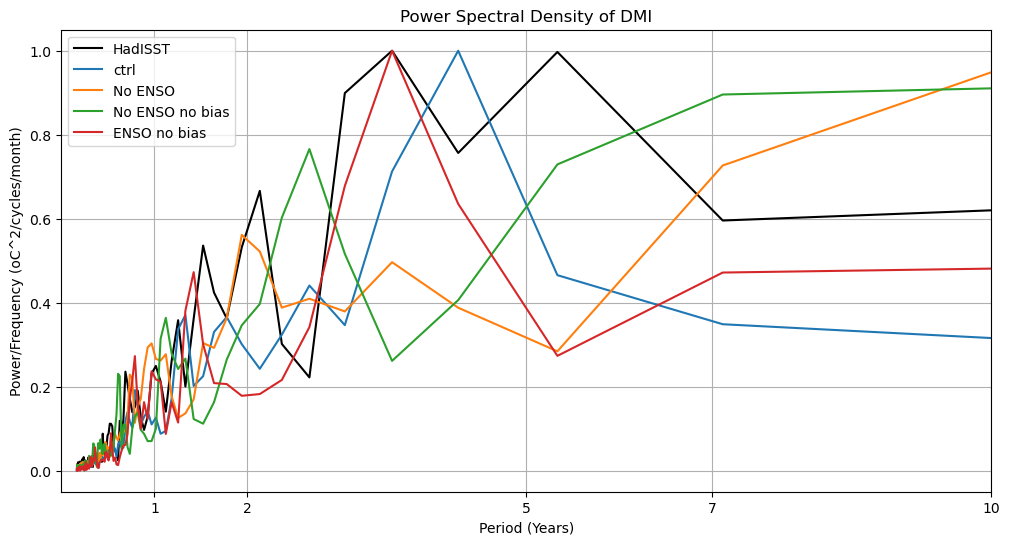

In [41]:
plt.figure(figsize=(12, 6))
for key in dmis.keys():
    dmi_data = dmis[key]
    frequencies, psd = welch(dmi_data)#, window = "hann")
    frequencies_cpy = frequencies * 12
    # Convert frequencies to period in years
    period_years = 1 / frequencies_cpy
    # Sort periods and corresponding PSD values in descending order
    # This ensures longest periods are on the left (highest period values)
    indices = np.argsort(-period_years)  # negative sign for descending sort
    sorted_periods = period_years[indices]
    sorted_psd = psd[indices]
    #normalise psd
    sorted_psd_norm = sorted_psd/abs(sorted_psd.max())
    plt.plot(sorted_periods, sorted_psd_norm, label = key, c = cols[key])
    
plt.title('Power Spectral Density of DMI')
plt.xlabel('Period (Years)')
plt.xticks([1,2,5,7,10,15,20])
plt.xlim(0, 10)
plt.ylabel('Power/Frequency (oC^2/cycles/month)')
plt.legend()
plt.grid(True)

/jobfs/105888376.gadi-pbs/ipykernel_1620763/4026722363.py:7: RuntimeWarning: divide by zero encountered in divide
  period_years = 1 / frequencies_cpy


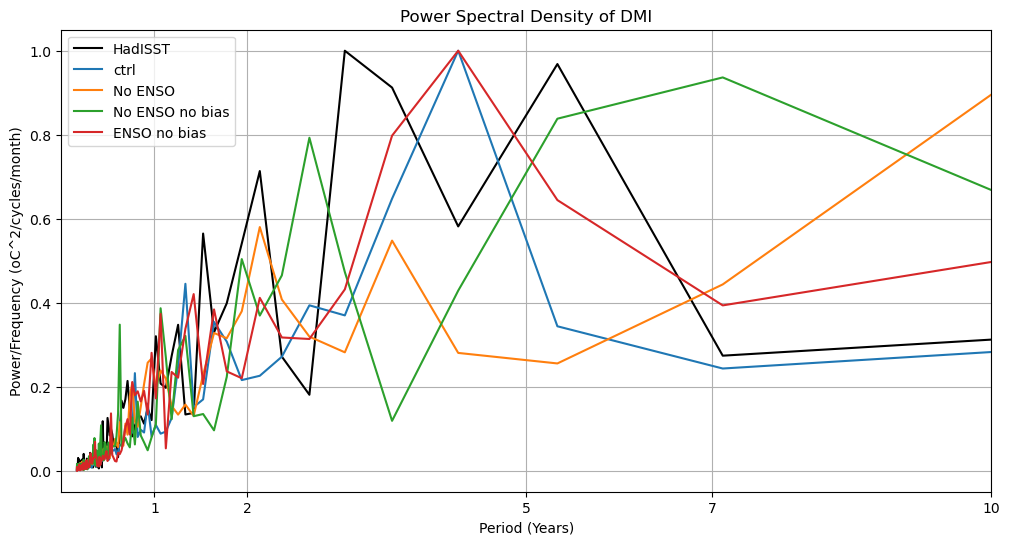

In [42]:
plt.figure(figsize=(12, 6))
for key in dmis.keys():
    dmi_data = dmis[key]
    frequencies, psd = welch(dmi_data, window = "boxcar")
    frequencies_cpy = frequencies * 12
    # Convert frequencies to period in years
    period_years = 1 / frequencies_cpy
    # Sort periods and corresponding PSD values in descending order
    # This ensures longest periods are on the left (highest period values)
    indices = np.argsort(-period_years)  # negative sign for descending sort
    sorted_periods = period_years[indices]
    sorted_psd = psd[indices]
    #normalise psd
    sorted_psd_norm = sorted_psd/abs(sorted_psd.max())
    plt.plot(sorted_periods, sorted_psd_norm, label = key, c = cols[key])
    
plt.title('Power Spectral Density of DMI')
plt.xlabel('Period (Years)')
plt.xticks([1,2,5,7,10,15,20])
plt.xlim(0, 10)
plt.ylabel('Power/Frequency (oC^2/cycles/month)')
plt.legend()
plt.grid(True)

In [81]:
import statsmodels.api as sm

In [83]:
dmi_data = NINO34(hadsst)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 70 times more chunks
  return self.array[key]


In [ ]:
# Calculate Power Spectral Density using Welch's method
frequencies, psd = welch(dmi_data, window = "boxcar")

In [88]:
ar_model = sm.tsa.AutoReg(dmi_data,lags=4).fit()

ValueError: unrecognized data structures: <class 'xarray.core.dataarray.DataArray'> / <class 'NoneType'>

/jobfs/105847057.gadi-pbs/ipykernel_2667527/1125084005.py:3: RuntimeWarning: divide by zero encountered in divide
  period_years = 1 / frequencies_cpy


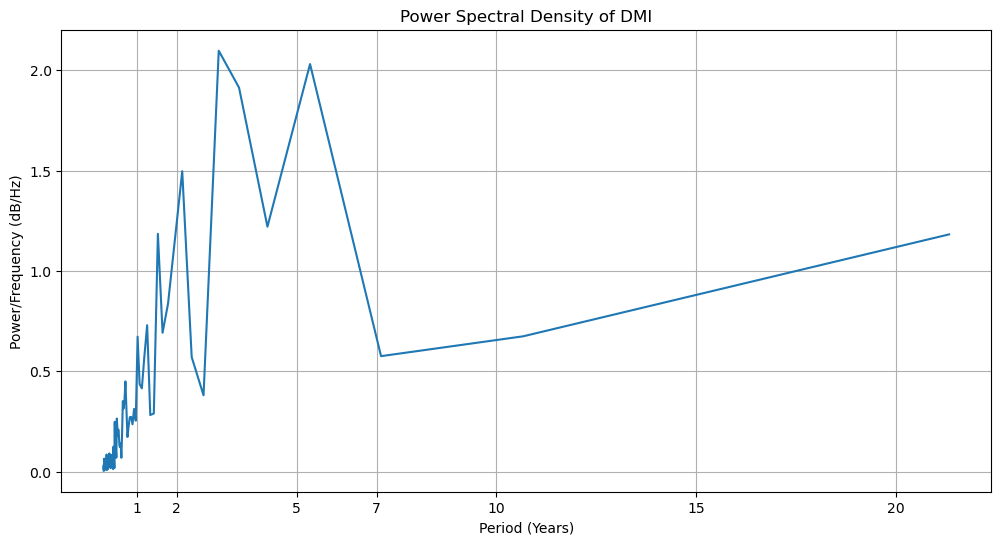

In [67]:
frequencies_cpy = frequencies * 12
# Convert frequencies to period in years
period_years = 1 / frequencies_cpy

# Sort periods and corresponding PSD values in descending order
# This ensures longest periods are on the left (highest period values)
indices = np.argsort(-period_years)  # negative sign for descending sort
sorted_periods = period_years[indices]
sorted_psd = psd[indices]

# Plotting the Power Spectral Density
plt.figure(figsize=(12, 6))
plt.plot(sorted_periods, sorted_psd)
plt.title('Power Spectral Density of DMI')
plt.xlabel('Period (Years)')
plt.xticks([1,2,5,7,10,15,20])
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)

/jobfs/105888376.gadi-pbs/ipykernel_1620763/2680808891.py:9: RuntimeWarning: divide by zero encountered in divide
  period_years = 1 / frequencies_cpy


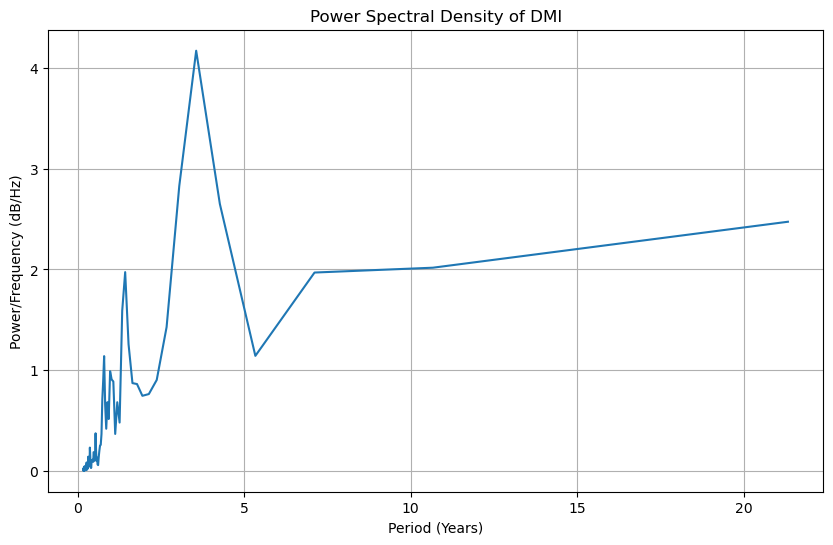

In [40]:
fs = 1/12  # one sample per month

# Calculate Power Spectral Density using Welch's method
frequencies, psd = welch(dmi_data, return_onesided = True)

# Convert frequencies to cycles per year
frequencies_cpy = frequencies * 12
# Convert frequencies to period in years
period_years = 1 / frequencies_cpy

# Plotting the Power Spectral Density
plt.figure(figsize=(10, 6))
plt.plot(period_years, psd)
plt.title('Power Spectral Density of DMI')
plt.xlabel('Period (Years)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)
plt.show()

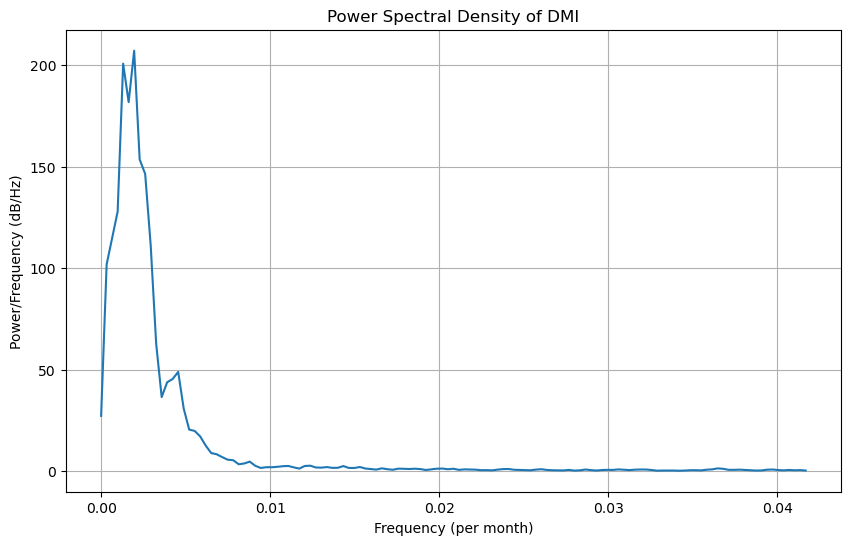

In [96]:
fs = 1/12  # one sample per month

# Calculate Power Spectral Density using Welch's method
frequencies, psd = welch(dmi_data, fs)

# Plotting the Power Spectral Density
plt.figure(figsize=(10, 6))
plt.plot(frequencies, psd)
plt.title('Power Spectral Density of DMI')
plt.xlabel('Frequency (per month)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)

In [83]:
labels=[50,10,5,2,1]
ticks=[1/(50*12), 1/(10*12), 1/(5*12), 1/(2*12), 1/12]

Text(0.5, 0, 'Years/cycle')

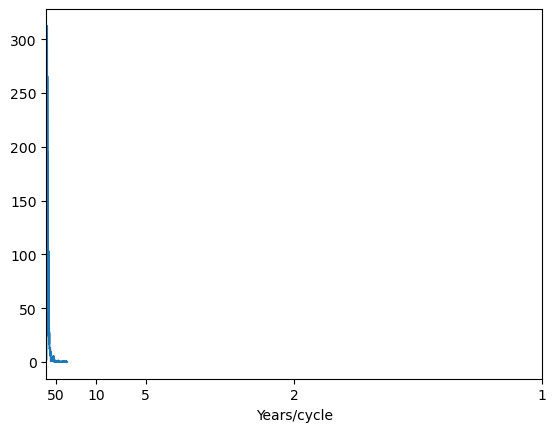

In [85]:
plt.plot(frequencies, psd)
plt.xlim(0,0.1)
plt.xticks(ticks=ticks, labels=labels)
plt.xlabel('Years/cycle')

In [80]:
1/(10*12)

0.008333333333333333

In [79]:
1/(50*12)

0.0016666666666666668

/jobfs/105736691.gadi-pbs/ipykernel_2742654/792295473.py:9: RuntimeWarning: divide by zero encountered in divide
  cycles_per_year = 1 / frequencies_cpy


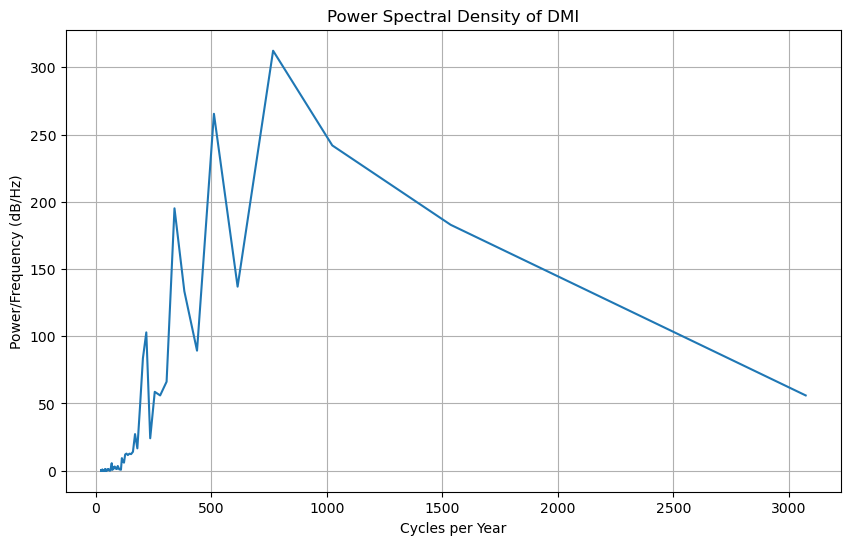

In [74]:
fs = 1/12  # one sample per month

# Calculate Power Spectral Density using Welch's method
frequencies, psd = welch(dmi_data, fs)

# Convert frequencies to cycles per year
frequencies_cpy = frequencies 
# Invert frequencies to represent cycles per year
cycles_per_year = 1 / frequencies_cpy

# Plotting the Power Spectral Density
plt.figure(figsize=(10, 6))
plt.plot(cycles_per_year, psd)
plt.title('Power Spectral Density of DMI')
plt.xlabel('Cycles per Year')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)


In [18]:
ppiod, epiod, piod, pniod, eniod, niod = three_types_IOD(ctrl_sst)

In [19]:
vppiod, vepiod, vpiod, vpniod, veniod, vniod = three_types_IOD(VC_sst)
oppiod, oepiod, opiod, opniod, oeniod, oniod = three_types_IOD(OC_sst)
mppiod, mepiod, mpiod, mpniod, meniod, mniod = three_types_IOD(MC_sst)

In [49]:
len(piod)/12

12.0

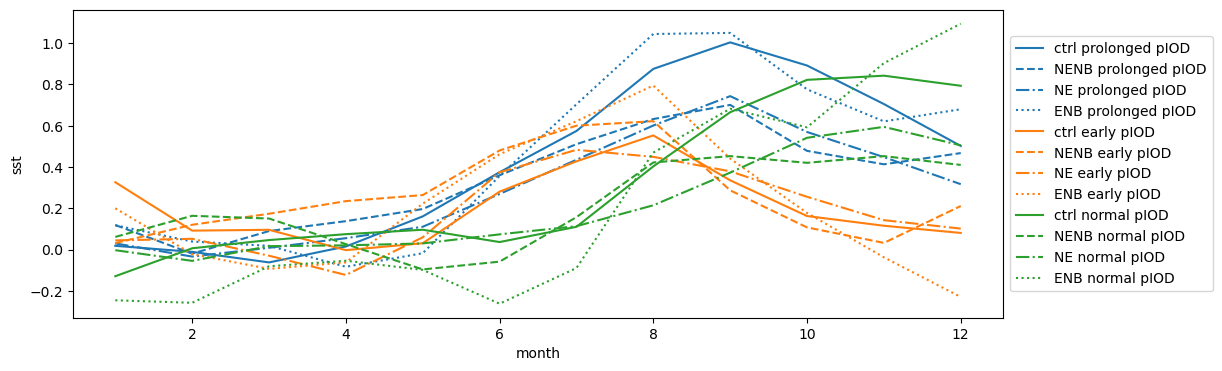

In [28]:
plt.figure(figsize=(12,4))
ppiod.groupby("time.month").mean("time").plot(label = "ctrl prolonged pIOD", c="tab:blue", ls = '-')
oppiod.groupby("time.month").mean("time").plot(label = "NENB prolonged pIOD", c="tab:blue", ls = '--')
mppiod.groupby("time.month").mean("time").plot(label = "NE prolonged pIOD", c="tab:blue", ls = '-.')
vppiod.groupby("time.month").mean("time").plot(label = "ENB prolonged pIOD", c="tab:blue", ls = ':')

epiod.groupby("time.month").mean("time").plot(label = "ctrl early pIOD", c="tab:orange", ls = '-')
oepiod.groupby("time.month").mean("time").plot(label = "NENB early pIOD", c="tab:orange", ls = '--')
mepiod.groupby("time.month").mean("time").plot(label = "NE early pIOD", c="tab:orange", ls = '-.')
vepiod.groupby("time.month").mean("time").plot(label = "ENB early pIOD", c="tab:orange", ls = ':')

piod.groupby("time.month").mean("time").plot(label = "ctrl normal pIOD", c="tab:green", ls = '-')
opiod.groupby("time.month").mean("time").plot(label = "NENB normal pIOD", c="tab:green", ls = '--')
mpiod.groupby("time.month").mean("time").plot(label = "NE normal pIOD", c="tab:green", ls = '-.')
vpiod.groupby("time.month").mean("time").plot(label = "ENB normal pIOD", c="tab:green", ls = ':')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

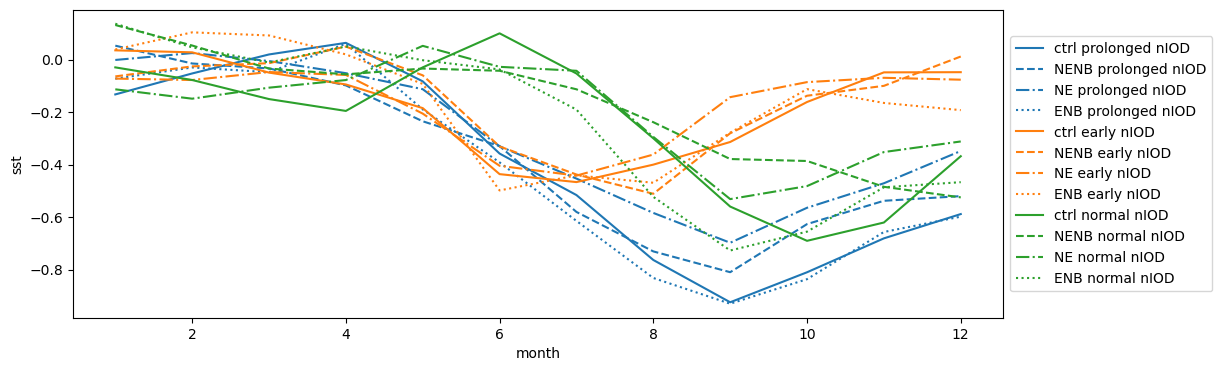

In [27]:
plt.figure(figsize=(12,4))
pniod.groupby("time.month").mean("time").plot(label = "ctrl prolonged nIOD", c="tab:blue", ls = '-')
opniod.groupby("time.month").mean("time").plot(label = "NENB prolonged nIOD", c="tab:blue", ls = '--')
mpniod.groupby("time.month").mean("time").plot(label = "NE prolonged nIOD", c="tab:blue", ls = '-.')
vpniod.groupby("time.month").mean("time").plot(label = "ENB prolonged nIOD", c="tab:blue", ls = ':')

eniod.groupby("time.month").mean("time").plot(label = "ctrl early nIOD", c="tab:orange", ls = '-')
oeniod.groupby("time.month").mean("time").plot(label = "NENB early nIOD", c="tab:orange", ls = '--')
meniod.groupby("time.month").mean("time").plot(label = "NE early nIOD", c="tab:orange", ls = '-.')
veniod.groupby("time.month").mean("time").plot(label = "ENB early nIOD", c="tab:orange", ls = ':')

niod.groupby("time.month").mean("time").plot(label = "ctrl normal nIOD", c="tab:green", ls = '-')
oniod.groupby("time.month").mean("time").plot(label = "NENB normal nIOD", c="tab:green", ls = '--')
mniod.groupby("time.month").mean("time").plot(label = "NE normal nIOD", c="tab:green", ls = '-.')
vniod.groupby("time.month").mean("time").plot(label = "ENB normal nIOD", c="tab:green", ls = ':')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

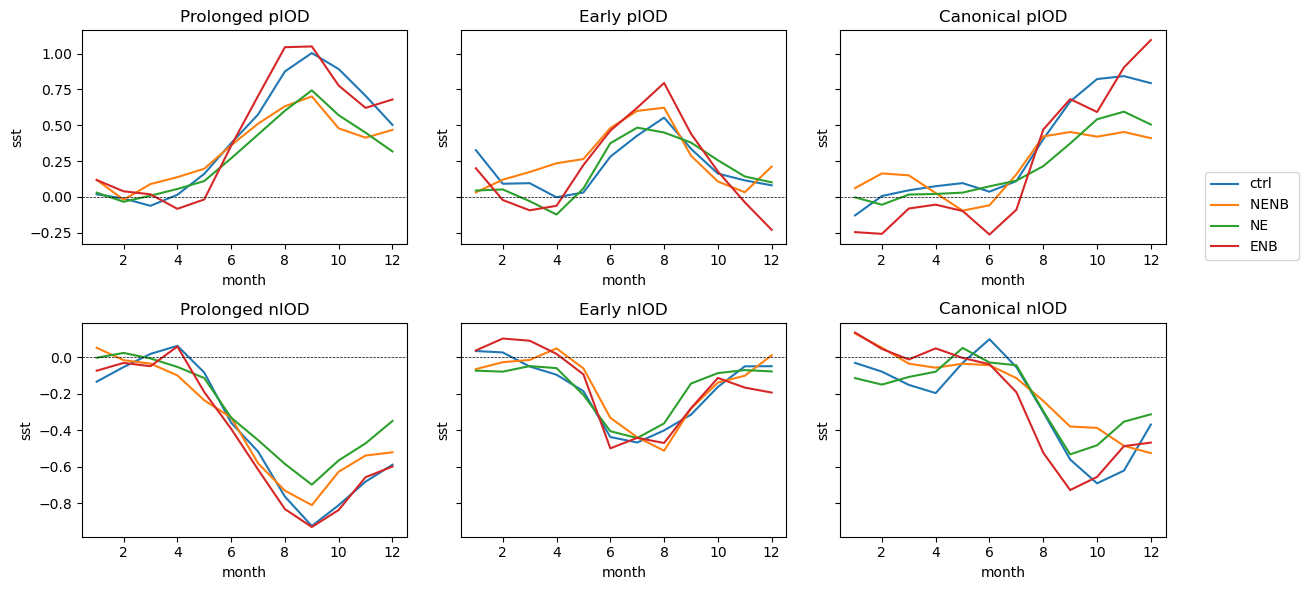

In [77]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharey="row")

# Plot 1
ppiod.groupby("time.month").mean("time").plot(ax=axs[0, 0], label="ctrl prolonged pIOD", c="tab:blue")
oppiod.groupby("time.month").mean("time").plot(ax=axs[0, 0], label="NENB prolonged pIOD", c="tab:orange")
mppiod.groupby("time.month").mean("time").plot(ax=axs[0, 0], label="NE prolonged pIOD", c="tab:green")
vppiod.groupby("time.month").mean("time").plot(ax=axs[0, 0], label="ENB prolonged pIOD", c="tab:red")

# Plot 2
epiod.groupby("time.month").mean("time").plot(ax=axs[0, 1], label="ctrl early pIOD", c="tab:blue")
oepiod.groupby("time.month").mean("time").plot(ax=axs[0, 1], label="NENB early pIOD", c="tab:orange")
mepiod.groupby("time.month").mean("time").plot(ax=axs[0, 1], label="NE early pIOD", c="tab:green")
vepiod.groupby("time.month").mean("time").plot(ax=axs[0, 1], label="ENB early pIOD", c="tab:red")

# Plot 3
piod.groupby("time.month").mean("time").plot(ax=axs[0, 2], label="ctrl normal pIOD", c="tab:blue")
opiod.groupby("time.month").mean("time").plot(ax=axs[0, 2], label="NENB normal pIOD", c="tab:orange")
mpiod.groupby("time.month").mean("time").plot(ax=axs[0, 2], label="NE normal pIOD", c="tab:green")
vpiod.groupby("time.month").mean("time").plot(ax=axs[0, 2], label="ENB normal pIOD", c="tab:red")

# Plot 4
pniod.groupby("time.month").mean("time").plot(ax=axs[1, 0], label="ctrl prolonged nIOD", c="tab:blue")
opniod.groupby("time.month").mean("time").plot(ax=axs[1, 0], label="NENB prolonged nIOD", c="tab:orange")
mpniod.groupby("time.month").mean("time").plot(ax=axs[1, 0], label="NE prolonged nIOD", c="tab:green")
vpniod.groupby("time.month").mean("time").plot(ax=axs[1, 0], label="ENB prolonged nIOD", c="tab:red")

# Plot 5
eniod.groupby("time.month").mean("time").plot(ax=axs[1, 1], label="ctrl early nIOD", c="tab:blue")
oeniod.groupby("time.month").mean("time").plot(ax=axs[1, 1], label="NENB early nIOD", c="tab:orange")
meniod.groupby("time.month").mean("time").plot(ax=axs[1, 1], label="NE early nIOD", c="tab:green")
veniod.groupby("time.month").mean("time").plot(ax=axs[1, 1], label="ENB early nIOD", c="tab:red")

# Plot 6
niod.groupby("time.month").mean("time").plot(ax=axs[1, 2], label="ctrl", c="tab:blue")
oniod.groupby("time.month").mean("time").plot(ax=axs[1, 2], label="NENB ", c="tab:orange")
mniod.groupby("time.month").mean("time").plot(ax=axs[1, 2], label="NE", c="tab:green")
vniod.groupby("time.month").mean("time").plot(ax=axs[1, 2], label="ENB", c="tab:red")
#add dotted line at y = 0
for ax in axs.flatten():
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
axs[0, 0].set_title("Prolonged pIOD")
axs[0, 1].set_title("Early pIOD")
axs[0, 2].set_title("Canonical pIOD")
axs[1, 0].set_title("Prolonged nIOD")
axs[1, 1].set_title("Early nIOD")
axs[1, 2].set_title("Canonical nIOD")
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1.1, 1.5))

In [76]:
#look at the proportion of each events type
print(len(ppiod.groupby('time.year').mean("time")))
print(len(epiod.groupby('time.year').mean("time")))
print(len(piod.groupby('time.year').mean("time")))

28
12
12


In [66]:
print(len(pniod.groupby('time.year').mean("time")))
print(len(eniod.groupby('time.year').mean("time")))
print(len(niod.groupby('time.year').mean("time")))

23
18
18


In [67]:
print(len(oppiod.groupby('time.year').mean("time")))
print(len(oepiod.groupby('time.year').mean("time")))
print(len(opiod.groupby('time.year').mean("time")))

9
5
5


In [68]:
print(len(mppiod.groupby('time.year').mean("time")))
print(len(mepiod.groupby('time.year').mean("time")))
print(len(mpiod.groupby('time.year').mean("time")))

23
8
8


In [69]:
print(len(vppiod.groupby('time.year').mean("time")))
print(len(vepiod.groupby('time.year').mean("time")))
print(len(vpiod.groupby('time.year').mean("time")))

10
4
4


In [70]:
print(len(opniod.groupby('time.year').mean("time")))
print(len(oeniod.groupby('time.year').mean("time")))
print(len(oniod.groupby('time.year').mean("time")))

8
6
6


In [71]:
print(len(mpniod.groupby('time.year').mean("time")))
print(len(meniod.groupby('time.year').mean("time")))
print(len(mniod.groupby('time.year').mean("time")))

20
11
11


In [72]:
print(len(vpniod.groupby('time.year').mean("time")))
print(len(veniod.groupby('time.year').mean("time")))
print(len(vniod.groupby('time.year').mean("time")))

8
6
6


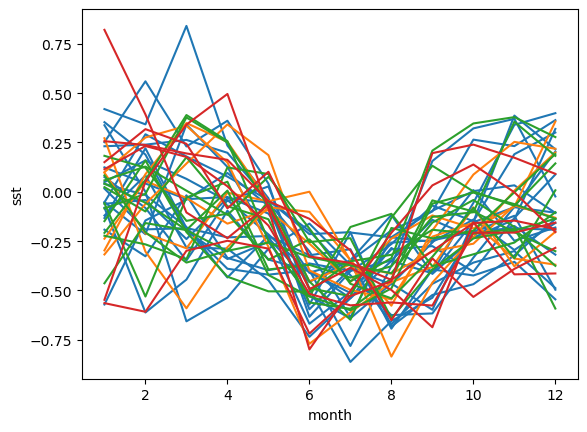

In [61]:
for yr, gp in epiod.groupby("time.year"):
    gp.groupby("time.month").mean("time").plot( label="ctrl prolonged pIOD", c="tab:blue")
for yr, gp in oepiod.groupby("time.year"):
    gp.groupby("time.month").mean("time").plot(label="NENB prolonged pIOD", c="tab:orange")
for yr, gp in mepiod.groupby("time.year"):
    gp.groupby("time.month").mean("time").plot(label="NE prolonged pIOD", c="tab:green")
for yr, gp in vepiod.groupby("time.year"):
    gp.groupby("time.month").mean("time").plot( label="ENB prolonged pIOD", c="tab:red")


In [76]:
nIOD, pIOD = get_IOD_times(ctrl_sst, DMI(ctrl_sst))

In [78]:
enIOD, epIOD = get_IOD_times(ctrl_sst, DMI(ctrl_sst))

In [96]:
enIOD_yrs = enIOD.groupby("time.year").mean("time").year

In [100]:
nIOD_yrs = nIOD.groupby("time.year").mean("time").year

In [102]:
overlap = np.intersect1d(enIOD_yrs.values, nIOD_yrs.values)

In [103]:
overlap

array([ 956,  958,  963,  979,  991,  992,  999, 1009, 1010, 1014, 1029,
       1033, 1037, 1041, 1054, 1059, 1064, 1072, 1095, 1096, 1100, 1122,
       1127, 1130, 1134, 1138, 1139, 1150])

In [104]:
early_only = np.setdiff1d(enIOD_yrs.values, nIOD_yrs.values)

In [105]:
norm_only = np.setdiff1d(nIOD_yrs.values, enIOD_yrs.values)

In [106]:
early_only

array([ 952,  955, 1038, 1045, 1065, 1069, 1076, 1077, 1088, 1099, 1116,
       1126])

In [110]:
#now go through DMI again and get these years only to make some subsets
gpd_years = DMI(ctrl_sst).groupby("time.year")
overlap_=[]
for year in overlap:
    overlap_.append(gpd_years[year])
early_=[]
for year in early_only:
    early_.append(gpd_years[year])
norm_=[]
for year in norm_only:
    norm_.append(gpd_years[year])

In [112]:
piod_prolonged = xr.concat(overlap_, dim = "time")

In [114]:
iod_prolonged = xr.concat(overlap_, dim = "time")
iod_early = xr.concat(early_, dim = "time")
iod_norm = xr.concat(norm_, dim = "time")

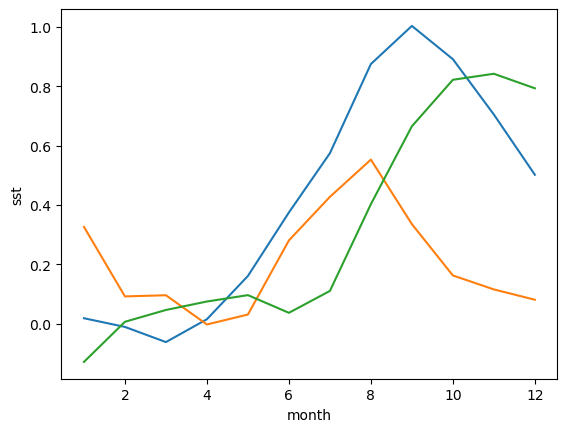

In [116]:
piod_prolonged.groupby("time.month").mean("time").plot()
piod_early.groupby("time.month").mean("time").plot()
piod_norm.groupby("time.month").mean("time").plot()

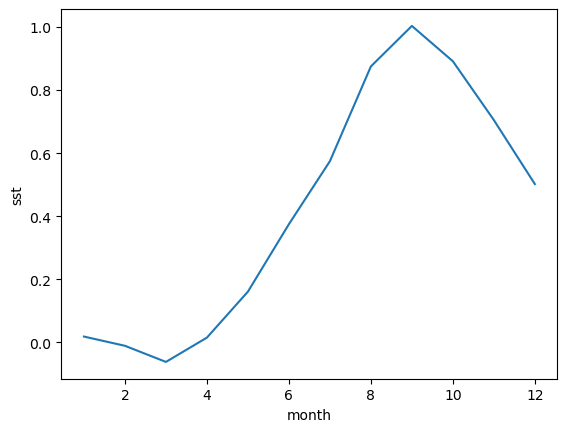

In [95]:
#DMI(ctrl_sst).plot()
nIOD.where(nIOD == enIOD).groupby('time.month').mean("time").plot()


In [11]:
#function to get the intersection and complements of niod and eniod and piod and epiod

In [12]:
nIOD, pIOD = IOD_events(ctrl_sst)
enIOD, epIOD = IOD_events_early(ctrl_sst)

# Calculate the mean year for nIOD and pIOD
nIOD = nIOD.groupby("time.year").mean("time").year
pIOD = pIOD.groupby("time.year").mean("time").year
enIOD = enIOD.groupby("time.year").mean("time").year
epIOD = epIOD.groupby("time.year").mean("time").year

In [16]:
enIOD

<xarray.DataArray 'year' (year: 41)>
array([ 953,  961,  975,  981,  982,  985,  988,  998, 1011, 1016, 1020, 1022,
       1023, 1026, 1027, 1028, 1031, 1034, 1035, 1036, 1043, 1051, 1053, 1063,
       1066, 1097, 1106, 1107, 1110, 1111, 1113, 1114, 1118, 1123, 1124, 1132,
       1133, 1136, 1140, 1141, 1147])
Coordinates:
  * year     (year) int64 953 961 975 981 982 985 ... 1133 1136 1140 1141 1147

In [17]:
nIOD

<xarray.DataArray 'year' (year: 41)>
array([ 959,  961,  970,  981,  985,  986,  988,  990,  994,  998, 1011, 1016,
       1023, 1028, 1031, 1035, 1036, 1040, 1043, 1048, 1051, 1053, 1056, 1058,
       1069, 1079, 1081, 1090, 1097, 1101, 1109, 1110, 1113, 1120, 1121, 1123,
       1124, 1133, 1137, 1141, 1147])
Coordinates:
  * year     (year) int64 959 961 970 981 985 986 ... 1124 1133 1137 1141 1147

In [37]:
nIOD

<xarray.DataArray 'year' (year: 41)>
array([ 959,  961,  970,  981,  985,  986,  988,  990,  994,  998, 1011, 1016,
       1023, 1028, 1031, 1035, 1036, 1040, 1043, 1048, 1051, 1053, 1056, 1058,
       1069, 1079, 1081, 1090, 1097, 1101, 1109, 1110, 1113, 1120, 1121, 1123,
       1124, 1133, 1137, 1141, 1147])
Coordinates:
  * year     (year) int64 959 961 970 981 985 986 ... 1124 1133 1137 1141 1147

In [49]:
#intersection
niod.where(nIOD.year == enIOD.year, drop = True)

ValueError: Dimensions {'year'} do not exist. Expected one or more of Frozen({'time': 41})

In [36]:
nIOD_int

<xarray.DataArray 'year' (year: 0)>
array([], dtype=float64)
Coordinates:
  * year     (year) int64

In [14]:
nIOD_int = nIOD.where(nIOD == enIOD)

In [98]:
concatenated = xr.concat([nIOD, enIOD], dim='year')

# Find non-overlapping times
non_overlap_times = concatenated.groupby('year').filter(lambda x: len(x) == 1)


AttributeError: 'DataArrayGroupBy' object has no attribute 'filter'

In [96]:
xr.where(nIOD != enIOD, 1, nIOD)

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'year' ('year',)

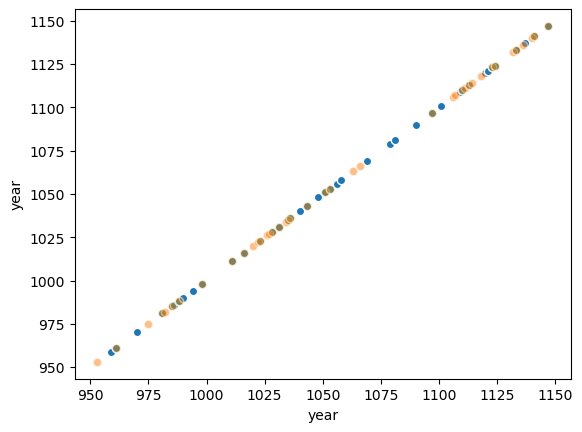

In [90]:
nIOD.plot.scatter()
enIOD.plot.scatter(alpha = 0.5)
nIOD_int.plot.scatter(alpha = 0.1)

In [ ]:
def get_IOD_times2(ds_sst, ds_var=None):
    """
    Subsets a variable based on the positive (pIOD) and negative (nIOD) Indian Ocean Dipole events derived from Sea Surface Temperature (SST) dataset.

    Parameters:
    ds_sst (xarray.Dataset): Sea Surface Temperature dataset containing IOD events.
    ds_var (xarray.Dataset, optional): Variable dataset to be subset based on IOD events. Defaults to None.

    Returns:
    tuple: Two subsets of the variable dataset corresponding to positive (subset_ds_pos) and negative (subset_ds_neg) IOD events.
    """
    # Extract positive and negative IOD events based on SST dataset
    nIOD, pIOD = IOD_events(ds_sst)
    enIOD, epIOD = IOD_events_early(ds_sst)

    # Calculate the mean year for nIOD and pIOD
    nIOD = nIOD.groupby("time.year").mean("time").year
    pIOD = pIOD.groupby("time.year").mean("time").year
    enIOD = enIOD.groupby("time.year").mean("time").year
    epIOD = epIOD.groupby("time.year").mean("time").year
    
    # If ds_var is not provided, use ds_sst
    if ds_var is None:
        ds_var = ds_sst
    
    # Resample ds_var by season and group by year
    ds_var = ds_var.resample(time='QS-DEC').mean(dim="time").groupby("time.year")
    
    # Initialize empty lists to store subsets
    pos_list = []
    neg_list = []
    
    # Loop through each year group in ds_var and subset based on specific years in nIOD and pIOD
    for year, group in ds_var:
        if year in pIOD:
            pos_subset = group
            pos_list.append(pos_subset)
        elif year in nIOD:
            neg_subset = group
            neg_list.append(neg_subset)
        else:
            pass
    
    # Concatenate subsets into a single DataArray
    subset_ds_pos = xr.concat(pos_list, dim='time')
    subset_ds_neg = xr.concat(neg_list, dim='time')
    
    return subset_ds_pos, subset_ds_neg


In [73]:
niod

<xarray.DataArray 'sst' (time: 41)>
array([-0.4900786 , -0.5251092 , -0.8904787 , -0.6808836 , -0.44991156,
       -0.58176494, -0.82968783, -0.5017175 , -0.62912035, -0.7360893 ,
       -0.6186566 , -0.6785424 , -0.7803528 , -0.7087333 , -0.6687338 ,
       -0.8067655 , -0.97947955, -0.8605477 , -0.8655515 , -0.4756746 ,
       -0.74577117, -0.7657232 , -0.49480352, -0.6025906 , -0.4746511 ,
       -0.87246346, -0.54773897, -0.51504034, -1.2290314 , -0.5870624 ,
       -0.5754772 , -1.1754831 , -0.917749  , -0.88514906, -0.4664558 ,
       -1.10247   , -1.0562731 , -0.8000982 , -0.7783354 , -0.83004236,
       -0.57483464], dtype=float32)
Coordinates:
  * time     (time) object 0959-09-01 00:00:00 ... 1147-09-01 00:00:00

In [72]:
eniod

<xarray.DataArray 'sst' (time: 41)>
array([-0.4888285 , -0.45701364, -0.40115538, -0.38804516, -0.4846109 ,
       -0.5281684 , -0.7086838 , -0.4800984 , -0.48972794, -0.9153655 ,
       -0.40779153, -0.4353344 , -0.5538773 , -0.31865057, -0.54472214,
       -0.41437486, -0.36005569, -0.367241  , -0.36476243, -0.5516295 ,
       -0.49982575, -0.3641781 , -0.5020392 , -0.66986305, -0.39310968,
       -0.46928725, -0.41524574, -0.38929352, -0.80751514, -0.5416483 ,
       -0.6706209 , -0.30682814, -0.3707011 , -0.50006175, -0.75345397,
       -0.5176187 , -0.41307664, -0.43358922, -0.33597708, -0.57605785,
       -0.7907135 ], dtype=float32)
Coordinates:
  * time     (time) object 0953-06-01 00:00:00 ... 1147-06-01 00:00:00